# Split lines into grid

In [106]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# aws connection*
import boto3
import awswrangler as wr

# local libraries
from src import utils

# analysis libraries
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import geopandas as gpd
import random
import itertools

import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon, MultiPolygon, LineString, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
from babelgrid import Babel

from multiprocessing.pool import Pool
from functools import partial

from loguru import logger

cm = str(datetime.today().strftime("%Y%m%d%H%m"))
cm

'202108161808'

## Sample dates



In [3]:
from src.runners.sample_jams import _sample_dates

In [4]:
df = _sample_dates(start_date = '2019-01-01', end_date = '2021-08-12')


2021-08-16 17:11:46.960 | DEBUG    | src.runners.sample_jams:_sample_dates:64 -            date
dow            
Friday       10
Monday       10
Thursday     10
Tuesday      10
Wednesday    10
2021-08-16 17:11:46.965 | DEBUG    | src.runners.sample_jams:_sample_dates:65 -       dow
year     
2019   19
2020   19
2021   12


In [ ]:
print(df.date_filter[0])

## Download sample

Query Athena once to download lines count to calculate jams

In [89]:
from src.runners import split_polygon

In [95]:
# Download data from Athena
update_data = False
if update_data:
    conn = utils.connect_athena(path='../configs/athena.yaml')
    qry = f"""
        select line_wkt, count(line_wkt) as count_lines
        from spd_sdv_waze_corona.raw_sample_jams
        group by line_wkt"""
    df_lines = pd.read_sql_query(qry, conn)
    
    # split lines
    df_lines = _split_groups(df_lines)
    df_lines.to_csv('/home/soniame/private/projects/corona_geo_id/lines/line_wkt_count_202010712.csv', index=False)


# Read current table
df_lines = pd.read_csv('/home/soniame/private/projects/corona_geo_id/lines/line_wkt_count_202010712.csv')
print(df_lines.shape)

(21904128, 3)


In [97]:
print(df_lines.shape)
df_lines.head(3)
3650688

(21904128, 3)


,line_wkt,count_lines,split
0,"linestring (-35.232974 -5.731801,-35.233194 -5...",26,1
1,"linestring (-103.34963 20.733682,-103.350022 2...",84,1
2,"linestring (-103.270292 20.663531,-103.270276 ...",83,1


In [107]:
from siuba import group_by, summarize, _
(df_lines
  >> group_by(_.split)
  >> summarize(lines = _.line_wkt.count())
  )

,split,lines
0,1,3650688
1,2,3650688
2,3,3650688
3,4,3650688
4,5,3650688
5,6,3650688


## Polygons definitions

5970.269755


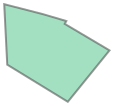

In [9]:
# - Example 
# polygon = 'POLYGON((2.0117187499999822 44.38657313925715,-19.433593750000018 19.207272119703983,19.414062499999982 6.904449621538131,64.94140624999999 -3.096801256840523,81.46484374999999 37.21269961002643,45.78124999999998 24.106495997107682,53.69140624999998 51.22054369437158,3.7695312499999822 37.07257833232809,2.0117187499999822 44.38657313925715))'
# - Latin America 
# polygon = 'POLYGON ((-127.265625 34.30714385628804, -128.671875 -56.94497418085159, -28.4765625 -57.70414723434192, -29.8828125 16.97274101999902, -84.72656249999999 25.48295117535531, -116.71874999999999 35.746512259918504, -127.265625 34.30714385628804))'
# - Triángulo 
# polygon = Polygon([(0, 0), (5, 5), (5, 0)])
# - Peru
# polygon = 'POLYGON ((-77.10205078124999 -13.004557745339769, -72.158203125 -13.004557745339769, -72.158203125 -8.90678000752024, -77.10205078124999 -8.90678000752024, -77.10205078124999 -13.004557745339769))'
# - Latin america BID
polygon = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
geometry = wkt.loads(polygon)
print(geometry.area)
geometry

## Coarse grid

In [6]:
from src.runners import split_polygon

In [7]:
# H3 cells grid
tiles = Babel('h3').polyfill(geometry, resolution=1)
# S2 cells grid
#tiles = Babel('s2').polyfill(geometry, resolution=4)
len(tiles)

if False:
    tiles_gdf = gpd.GeoDataFrame([t.to_dict() for t in tiles], geometry='shapely')
    df = tiles_gdf
    m = folium.Map(location=[40.70, -73.94], zoom_start=2, tiles='CartoDB positron')
    for _, r in df.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(r['shapely']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(m)
    m

In [13]:
tiles[0].geometry.wkt

'POLYGON ((-55.1640042079650925 -36.6429358436080577, -52.6054858825439382 -33.9363061513190800, -54.8549024329454653 -30.5120297313577140, -59.4966061400419974 -29.8929853386935527, -61.8827346387927903 -33.4390244823261540, -59.7881757300352632 -36.3948270591191658, -58.3098460295978711 -36.2052826524870781, -55.1640042079650925 -36.6429358436080577))'

In [8]:
prev = pd.read_csv("/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id.csv"). \
    rename(columns = {'line':'line_wkt'})

#    df_coarse.to_csv("/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new.csv", index = False)

In [20]:
print(prev.shape)
prev.head()

(1175153, 2)


,line_wkt,coarse_wkt
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",POLYGON ((-77.4406988355037527 5.5631423675199...
1,"LINESTRING(-100.921694 22.14878, -100.921864 2...",POLYGON ((-99.0040860771203626 15.551320300550...
2,"LINESTRING(-84.073469 9.962173, -84.073921 9.9...",POLYGON ((-89.8649065476102322 14.465456015426...
3,"LINESTRING(-101.001843 22.19166, -101.002284 2...",POLYGON ((-99.0040860771203626 15.551320300550...
4,"LINESTRING(-75.554978 6.3126, -75.554667 6.313...",POLYGON ((-76.7016783072784705 12.819508275225...


In [23]:
print(df_lines.shape)
print(df_merge.shape)
df_merge.head()

(21904128, 2)
(21904128, 3)


,line_wkt,count_lines,coarse_wkt
0,"linestring (-35.232974 -5.731801,-35.233194 -5...",26,NaN
1,"linestring (-103.34963 20.733682,-103.350022 2...",84,NaN
2,"linestring (-103.270292 20.663531,-103.270276 ...",83,NaN
3,"linestring (-99.14832 19.479112,-99.148334 19....",577,NaN
4,"linestring (-47.221241 -22.858412,-47.221295 -...",71,NaN


In [ ]:
lines = df_lines.line_wkt[:100]


In [ ]:
prev.line[:5]

In [ ]:
line = prev.line[0]

In [ ]:
sum(line == prev.line)

In [ ]:
# Partial processing
with Pool(10) as p:
    r = p.map(partial(line_to_coarse, tiles = tiles), df_lines.line_wkt[:5])
    
df_coarse = pd.DataFrame(r)    

In [ ]:
df_coarse

### Coarse grid distribution

In [ ]:
df_coarse = pd.read_csv("/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id.csv")

In [ ]:
print(len(df_coarse))
print(len(df_coarse.drop_duplicates()))
df_coarse.head(1)

In [ ]:
from siuba import group_by, ungroup, arrange, summarize, _

In [ ]:
tab = (df_coarse
  >> group_by(_.coarse_wkt)
  >> summarize(lines = _.line.count())
  >> ungroup()
  >> arrange("lines")
  )
tab.to_csv('/home/soniame/private/projects/corona_geo_id/coarse_grid_distribution.csv', index = False)
tab.head()

In [ ]:
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, legend=True, cmap='OrRd')

In [ ]:
fig, ax = plt.subplots(1, 1)
tab[tab.lines > 40000].plot(column='lines', ax=ax, legend=True, cmap='OrRd')

In [ ]:
tab[tab.lines > 40000]

## MultiLineString geometry

Testing the creation of MultiLineString

In [ ]:
from shapely.geometry import MultiLineString
#line_a = LineString(wkt.loads(line))
lines = [LineString(wkt.loads(line)) for line in df_lines.line_wkt]

In [ ]:
len(lines)
multi_line = MultiLineString(lines)
print(multi_line.length)
multi_line

In [ ]:
result = geometry.intersection(multi_line)

In [ ]:
times = [intersection_func(line, geometry) for line in df_lines.line_wkt[:5]]
total_lines = df_lines.count_lines
intersection = sum([times[x]*total_lines[x] for x in range(len(total))])
intersection

## Creating squares

In [ ]:
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
from shapely.wkt import loads

In [ ]:


def intersection_func(line, geometry):
    result = geometry.intersection(wkt.loads(line)).is_empty == False
    return(int(result))

def threshold_density_func(geometry, threshold_value, lines, jams):
    """Compares the threshold values with the number of lines"""
    
    print('Running')
    
    # Intersection of lines within square
    times = [intersection_func(line, geometry) for line in lines]
    jams = jams
    
    # Total lines in square
    intersection = sum([times[x]*jams[x] for x in range(len(total))])
    total = sum(total_lines)
    
    print(f"Intersection {intersection}")
    print(f"Total lines {total}")
    print(f"Proportion {intersection/total}")
    
    return (intersection/total) < (threshold_value/total)

In [ ]:
print(len(df_lines.line_wkt))
print(len(df_coarse.coarse_wkt))

In [ ]:
df_coarse.coarse_wkt.nunique()

In [ ]:
result = katana(geometry, 
                threshold_func = threshold_density_func, 
                threshold_value = 110000, 
                count = 100)

In [ ]:
len(result)

In [ ]:
multipolygon = MultiPolygon(result)
multipolygon

In [ ]:
grid = list()
for polygon in MultiPolygon(result):  # same for multipolygon.geoms
    grid.append(str(polygon))

In [ ]:
cm = str(datetime.today().strftime("%Y%m%d%H%m%s"))
print(cm)

In [ ]:
outdf = gpd.GeoDataFrame(columns=['geometry'])
outdf['geometry'] = grid
outdf.to_csv(f"~/private/geo_id_polygon/geo_grid_area_{cm}.csv")

## Lines intersection per square



In [ ]:
def intersection_line(line, geometry):
    #print(line)
    line_wkt = wkt.loads(str(line))
    result = geometry.intersection(line_wkt)
    
    return(result)

In [ ]:
df_lines['geo_id'] = ""
#df_lines.head()

In [ ]:
for polygon in outdf.geometry:
    print(polygon)
    
    geometry = wkt.loads(polygon)
    lines = df_lines[df_lines['geo_id'] == ''].line_wkt
    if len(lines) > 0:
        # print(len(lines))
        intersect = [intersection_func(line, geometry) for line in df_lines.line_wkt]
        df_lines.loc[[x > 0 for x in intersect], 'geo_id'] = polygon
    

In [ ]:
# Export 
df_lines.to_csv(f"~/private/geo_id_polygon/line_wkt_area_geo_id_{cm}.csv", index = False)

### Distribution of lines/jams per square

In [ ]:
from siuba import group_by, ungroup, arrange, summarize, _
import geopandas as gpd
import folium

In [ ]:
#df_geo_id = pd.read_csv(f"/home/soniame/private/projects/corona_geo_id/intersection/geo_grid_area_geo_id_2021073017071627679286.csv")
print(df_geo_id.shape)
df_geo_id.head()

In [ ]:
tab = (df_geo_id
  >> group_by(_.geo_id)
  >> summarize(lines = _.line_wkt.count())
  >> ungroup()
  >> arrange("lines")
  )
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')

tab.head()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, legend=True, cmap='OrRd')

In [ ]:
df = tab
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles='CartoDB positron')
for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['lines']).add_to(geo_j)
    geo_j.add_to(m)
m

In [ ]:
#centroid = tiles[0].geometry.centroid
#m = folium.Map(location=(centroid.latitude, centroid.longitude))


In [ ]:
for tile in tiles:
    folium.GeoJson(tile.geometry.geojson).add_to(m)
m